# Bio and neuro-imaging : Tomography and radon transform
## BAILLY Romain -- GOUGEON Esteban
### 3A SICOM 2019-2020

In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install scipy

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon, rescale
from skimage.data import shepp_logan_phantom
from skimage.util import random_noise
from skimage.draw import circle
import scipy.misc
from scipy import ndimage
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Introduction

The objective of this lab is to manipualte and understand the Radon transform and its limits. Radon transform is in fact used a lot for scanners thanks to its geometry. Radon transform is (in 2D cases) a sum of 1D signals obtained by rotation around an axe. It then uses the projection-slice theorem to reconstruct an image. It "combines" then all the 1D projection in order to create the inverse transform. We now better understand why scanners use this transform: by rotating around a body we can reconstruct the image of the body.

## I- Influence of dirac position on Radon transform

/srv/conda/envs/notebook/lib/python3.7/site-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


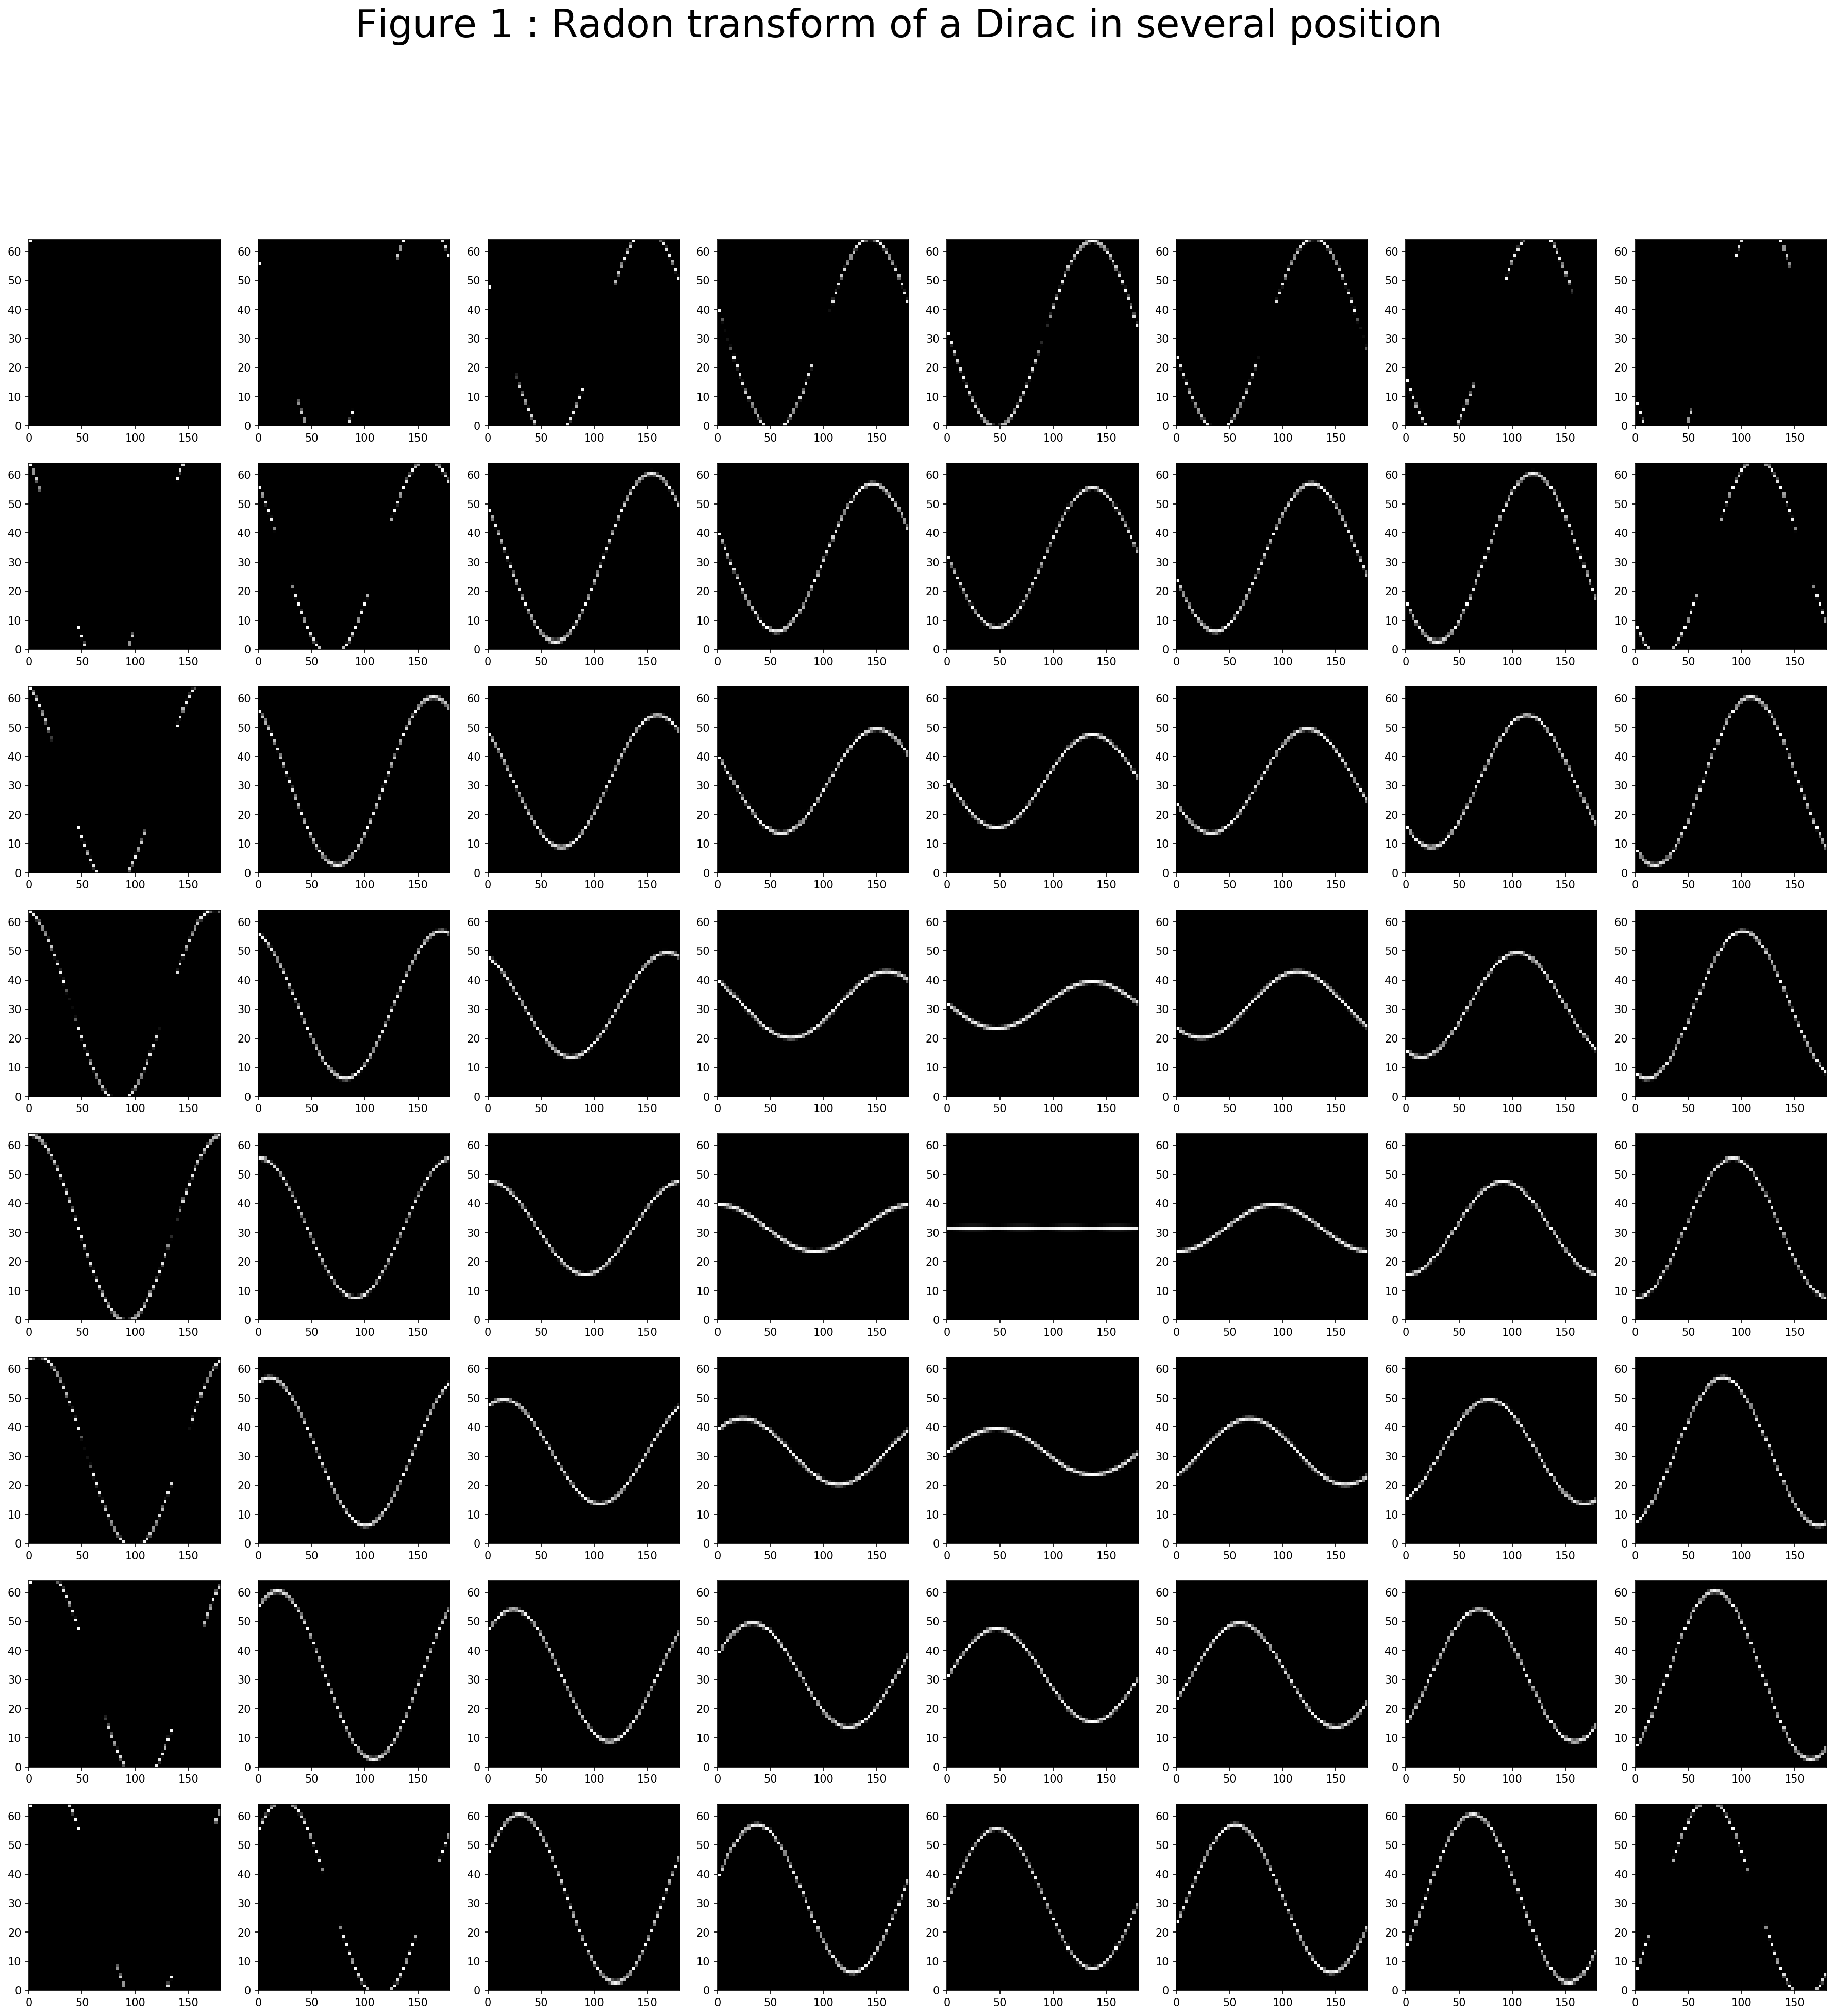

In [2]:
image = np.zeros((64, 64))

theta = np.linspace(0., 360., max(image.shape), endpoint=False)

fig, axs = plt.subplots(8, 8, figsize=(30,30), dpi=150)
fig.suptitle('Figure 1 : Radon transform of a Dirac in several position', fontsize=36)

for i in range(0, 63, 8):
    for j in range(0, 63, 8):
        image = image = np.zeros((64, 64)); image[i][j] = 1;
        
        sinogram = radon(image, theta=theta, circle=True)
        axs[i//8, j//8].imshow(sinogram, cmap=plt.cm.Greys_r,
               extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

plt.show()

Theorically, if we put a dirac of coordinates (x0,y0), the Radon transform will be a cosine. Several position are tried in the example above : a dirac is given each (8,8) in a 64x64 pixel image. The reference for the Radon tranform is the center of the image. In the Figure 1, we notice that all the result are in fact cosine. Moreover, the farther the dirac is from the center, the more amplitude the cosine has. And finally we notice that at same distance but different, angle, the phase of the cosine is different (cf II-2 Rotation effect). We can also notice that the middle point is giving a straight line (frequence = 0) and that all other results have the same frequency (given by the theta of the Radon transform).

## II- Circle's size and position
### II-1 Circle's size (here with gaussian shape)

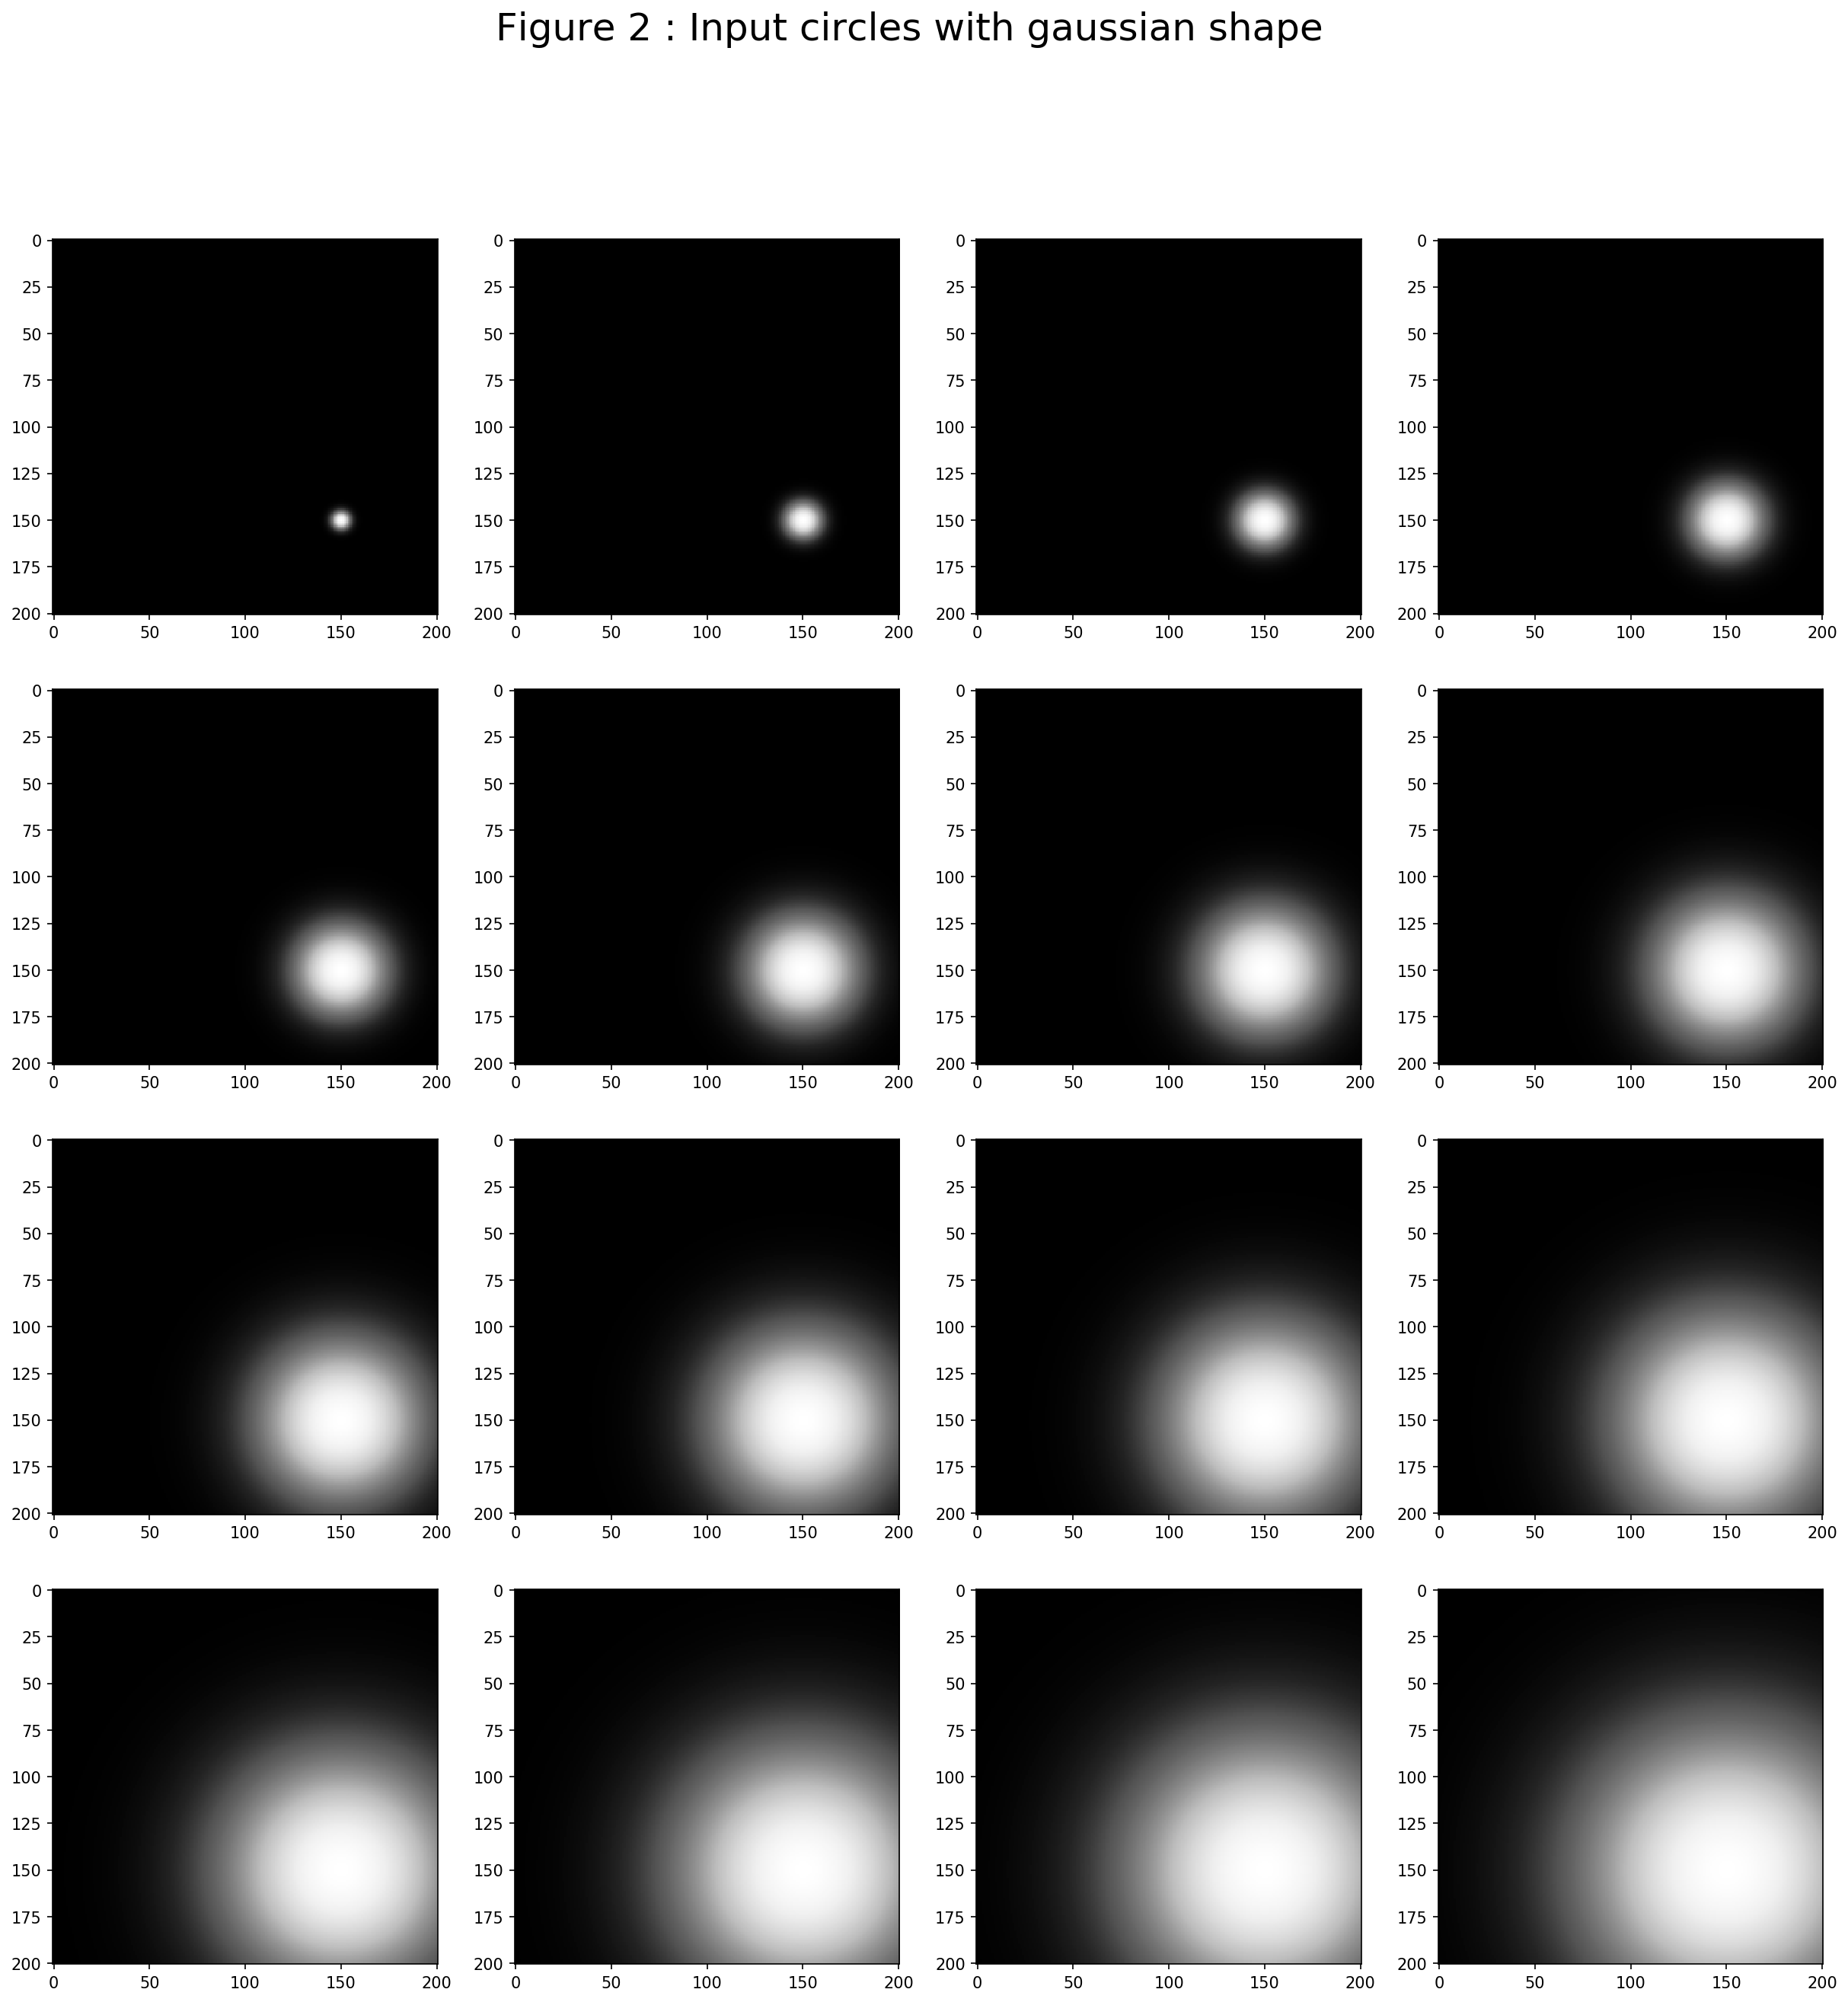

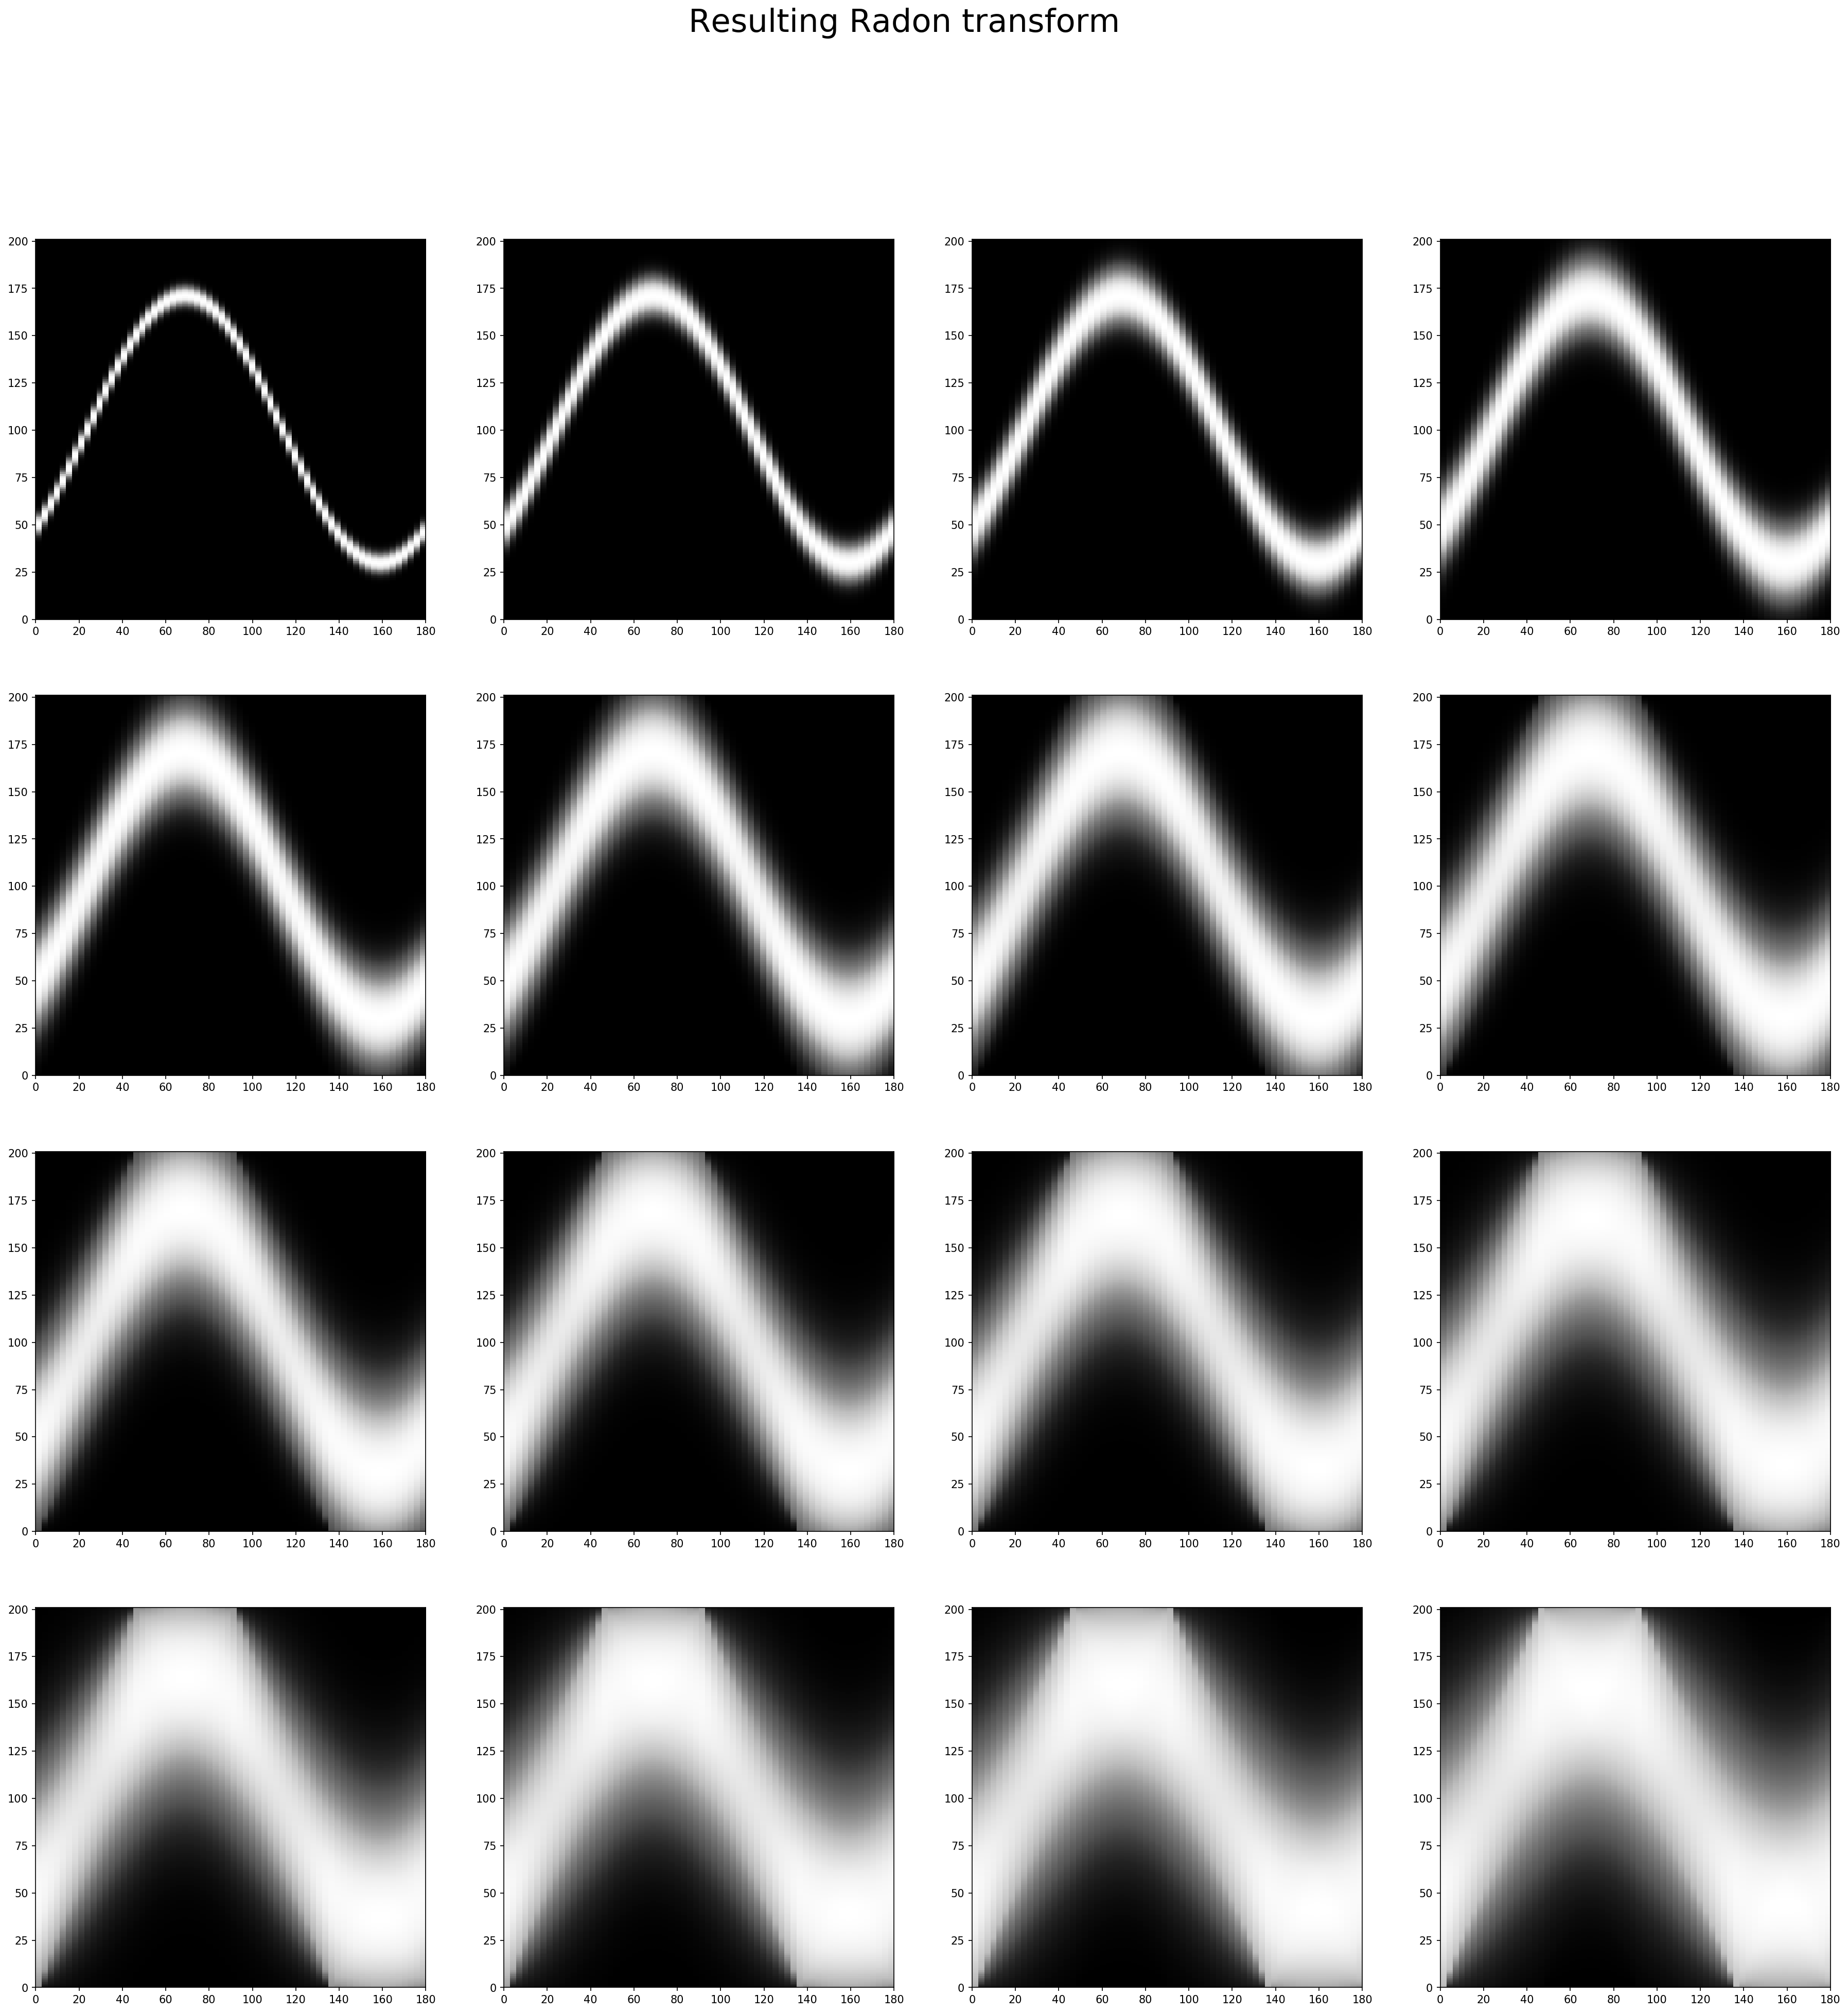

In [3]:
theta = np.linspace(0., 360., max(image.shape), endpoint=False)

fig, axs = plt.subplots(4, 4, figsize=(20,20), dpi=150)
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30), dpi=150)
pos_x, pos_y = 5, 5

fig.suptitle('Figure 2 : Input circles with gaussian shape', fontsize=24)
fig2.suptitle('Resulting Radon transform', fontsize=30)

for r in range (1, 17):
    sig_x, sig_y = 20,20
    sig = r*r / 9
    
    x = np.linspace(-10, 10, 201)
    y = np.linspace(-10, 10, 201)
    X,Y = np.meshgrid(x,y)
    
    image = np.exp(- ((X-pos_x)*(X-pos_x) + (Y-pos_y)*(Y-pos_y)) /(2*sig))
    axs[(r-1)//4, (r-1)%4].imshow(image, cmap=plt.cm.Greys_r, aspect='auto')
    
    sinogram = radon(image, theta=theta, circle=True)
    axs2[(r-1)//4, (r-1)%4].imshow(sinogram, cmap=plt.cm.Greys_r,
                          extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
plt.show()

The objective here is to observe the influence of the size of the dirac (becoming a circle) on the Radon transform. Radon Transform being additive, we expect a sum of cosine but slightly shifted. So theorically, we should have a blurred cosine. In the case of a circle with a gaussian shape, the blurry effect won't be as intense as a normal circle. That's what we can notice on the Figure 2. The cosine Radon transform is step by step growing with a blurry effect being more and more intense due to the gaussian shape. In the end we can barely recognize the cosine shape.

### II-2 Rotation effect

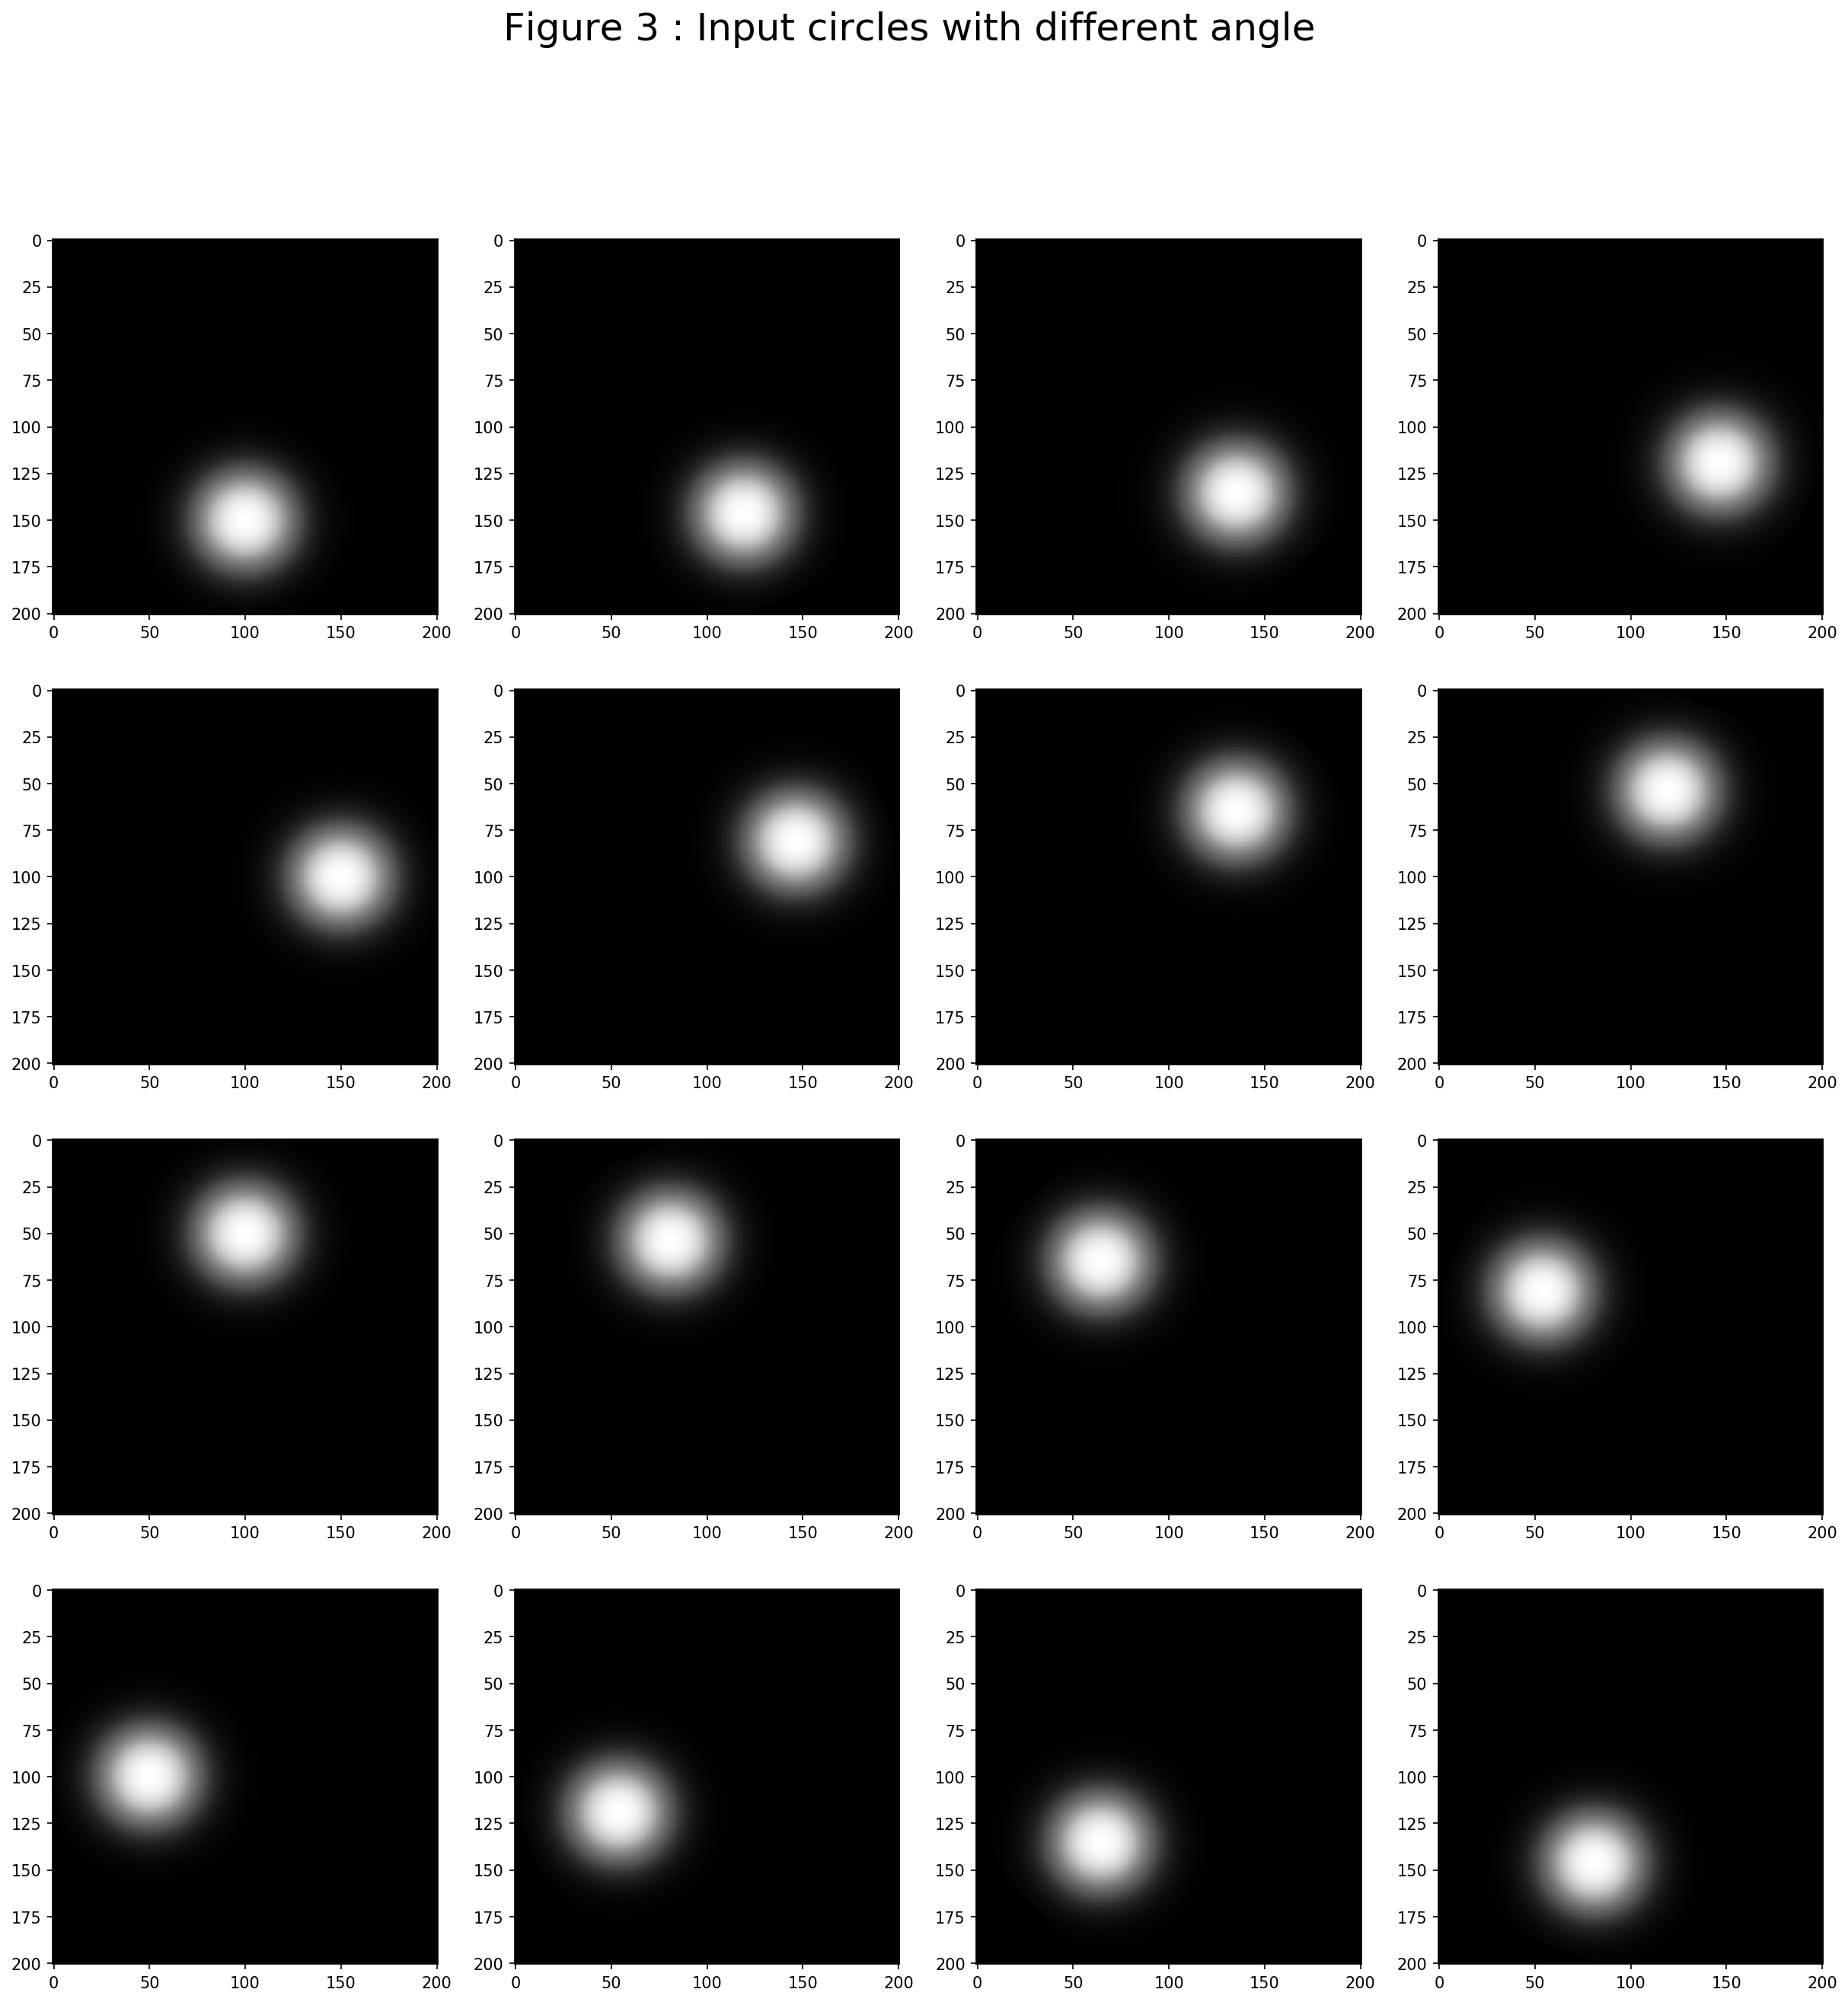

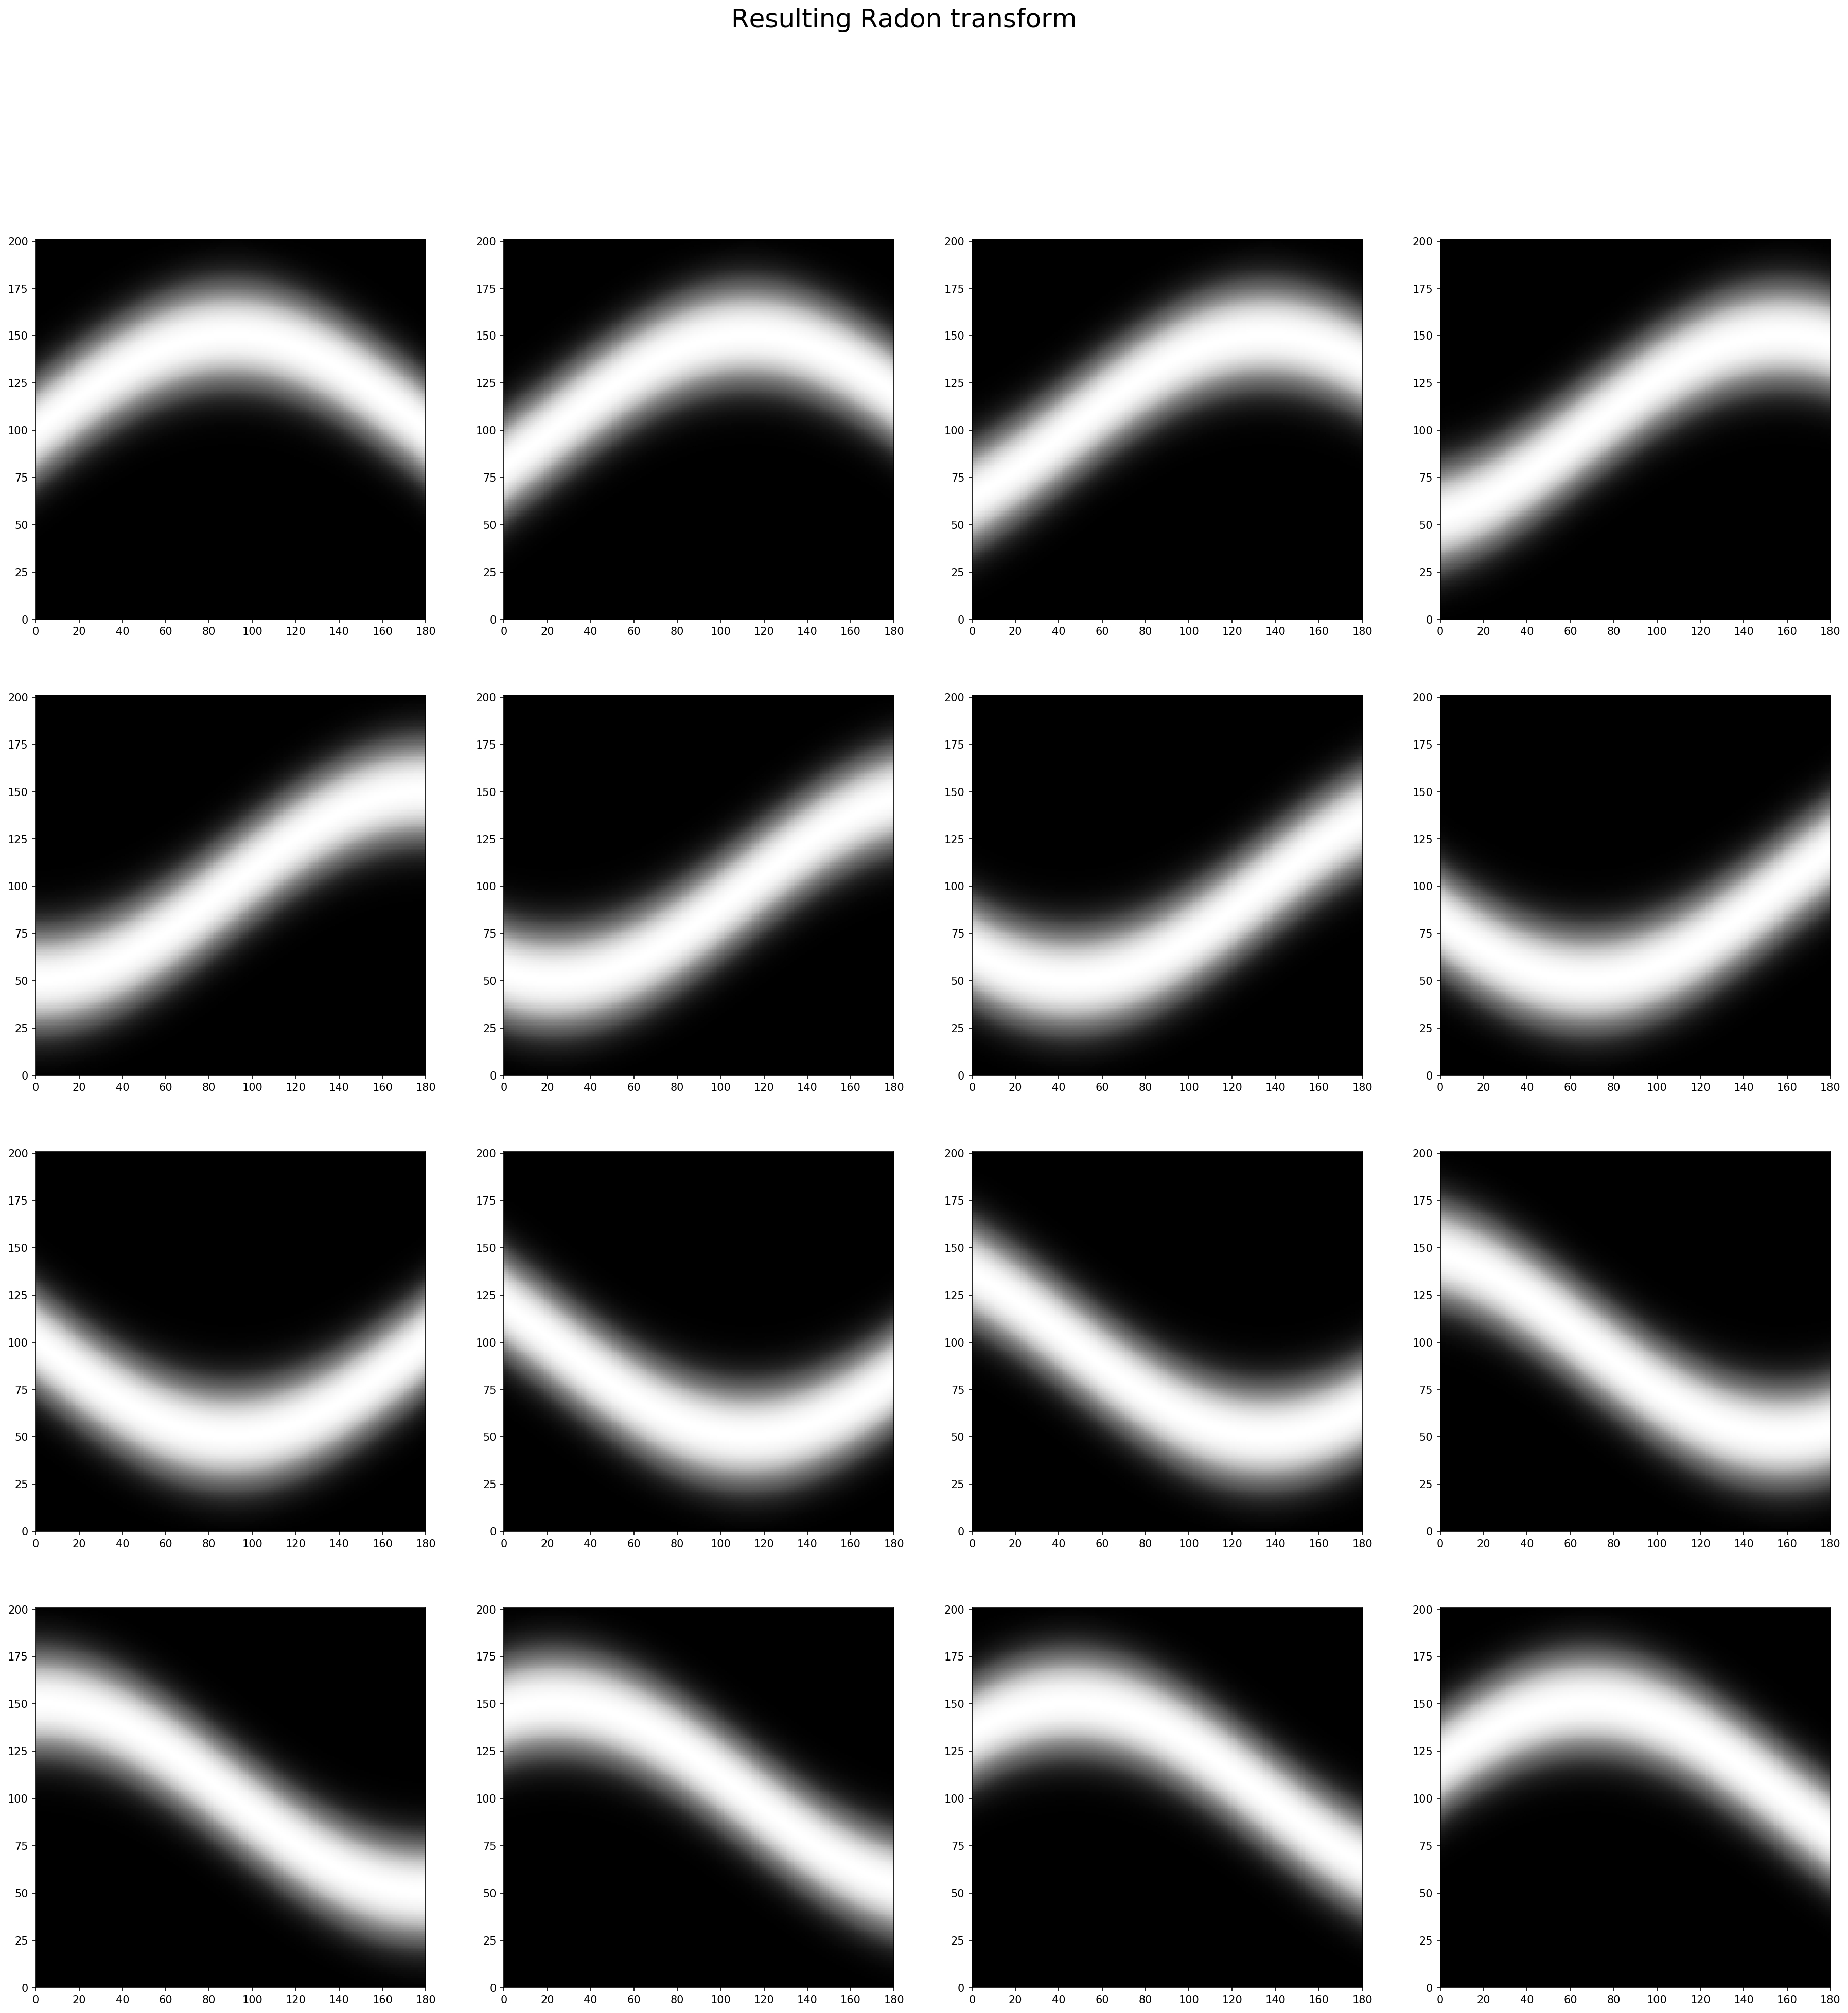

In [4]:
theta = np.linspace(0., 180., max(image.shape), endpoint=False)

fig, axs = plt.subplots(4, 4, figsize=(20,20), dpi=150)
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30), dpi=150)

fig.suptitle('Figure 3 : Input circles with different angle', fontsize=24)
fig2.suptitle('Resulting Radon transform', fontsize=24)

pos_y =  5
pos_x = 0
sig =  3

x = np.linspace(-10, 10, 201)
y = np.linspace(-10, 10, 201)
X,Y = np.meshgrid(x,y)
image = np.exp(- ((X-pos_x)*(X-pos_x) + (Y-pos_y)*(Y-pos_y)) /(2*sig))

for rot in range(16):
    sinogram = radon(image, theta=theta, circle=True)
    axs[rot//4, rot%4].imshow(image, cmap=plt.cm.Greys_r, aspect='auto')
    axs2[rot//4, rot%4].imshow(sinogram, cmap=plt.cm.Greys_r,
                          extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    image = ndimage.rotate(image, 360/16, reshape=False)
    
plt.show()

As seen in the first part, a rotation induces a change in the phase of the Radon transform. In fact this change is directly linked to the position of the object, being the angle between the reference and the object. It's coherent with the definition of the Radon transform.

## III- Radon transform on a practical exemple
### III-1 Reconstruction error

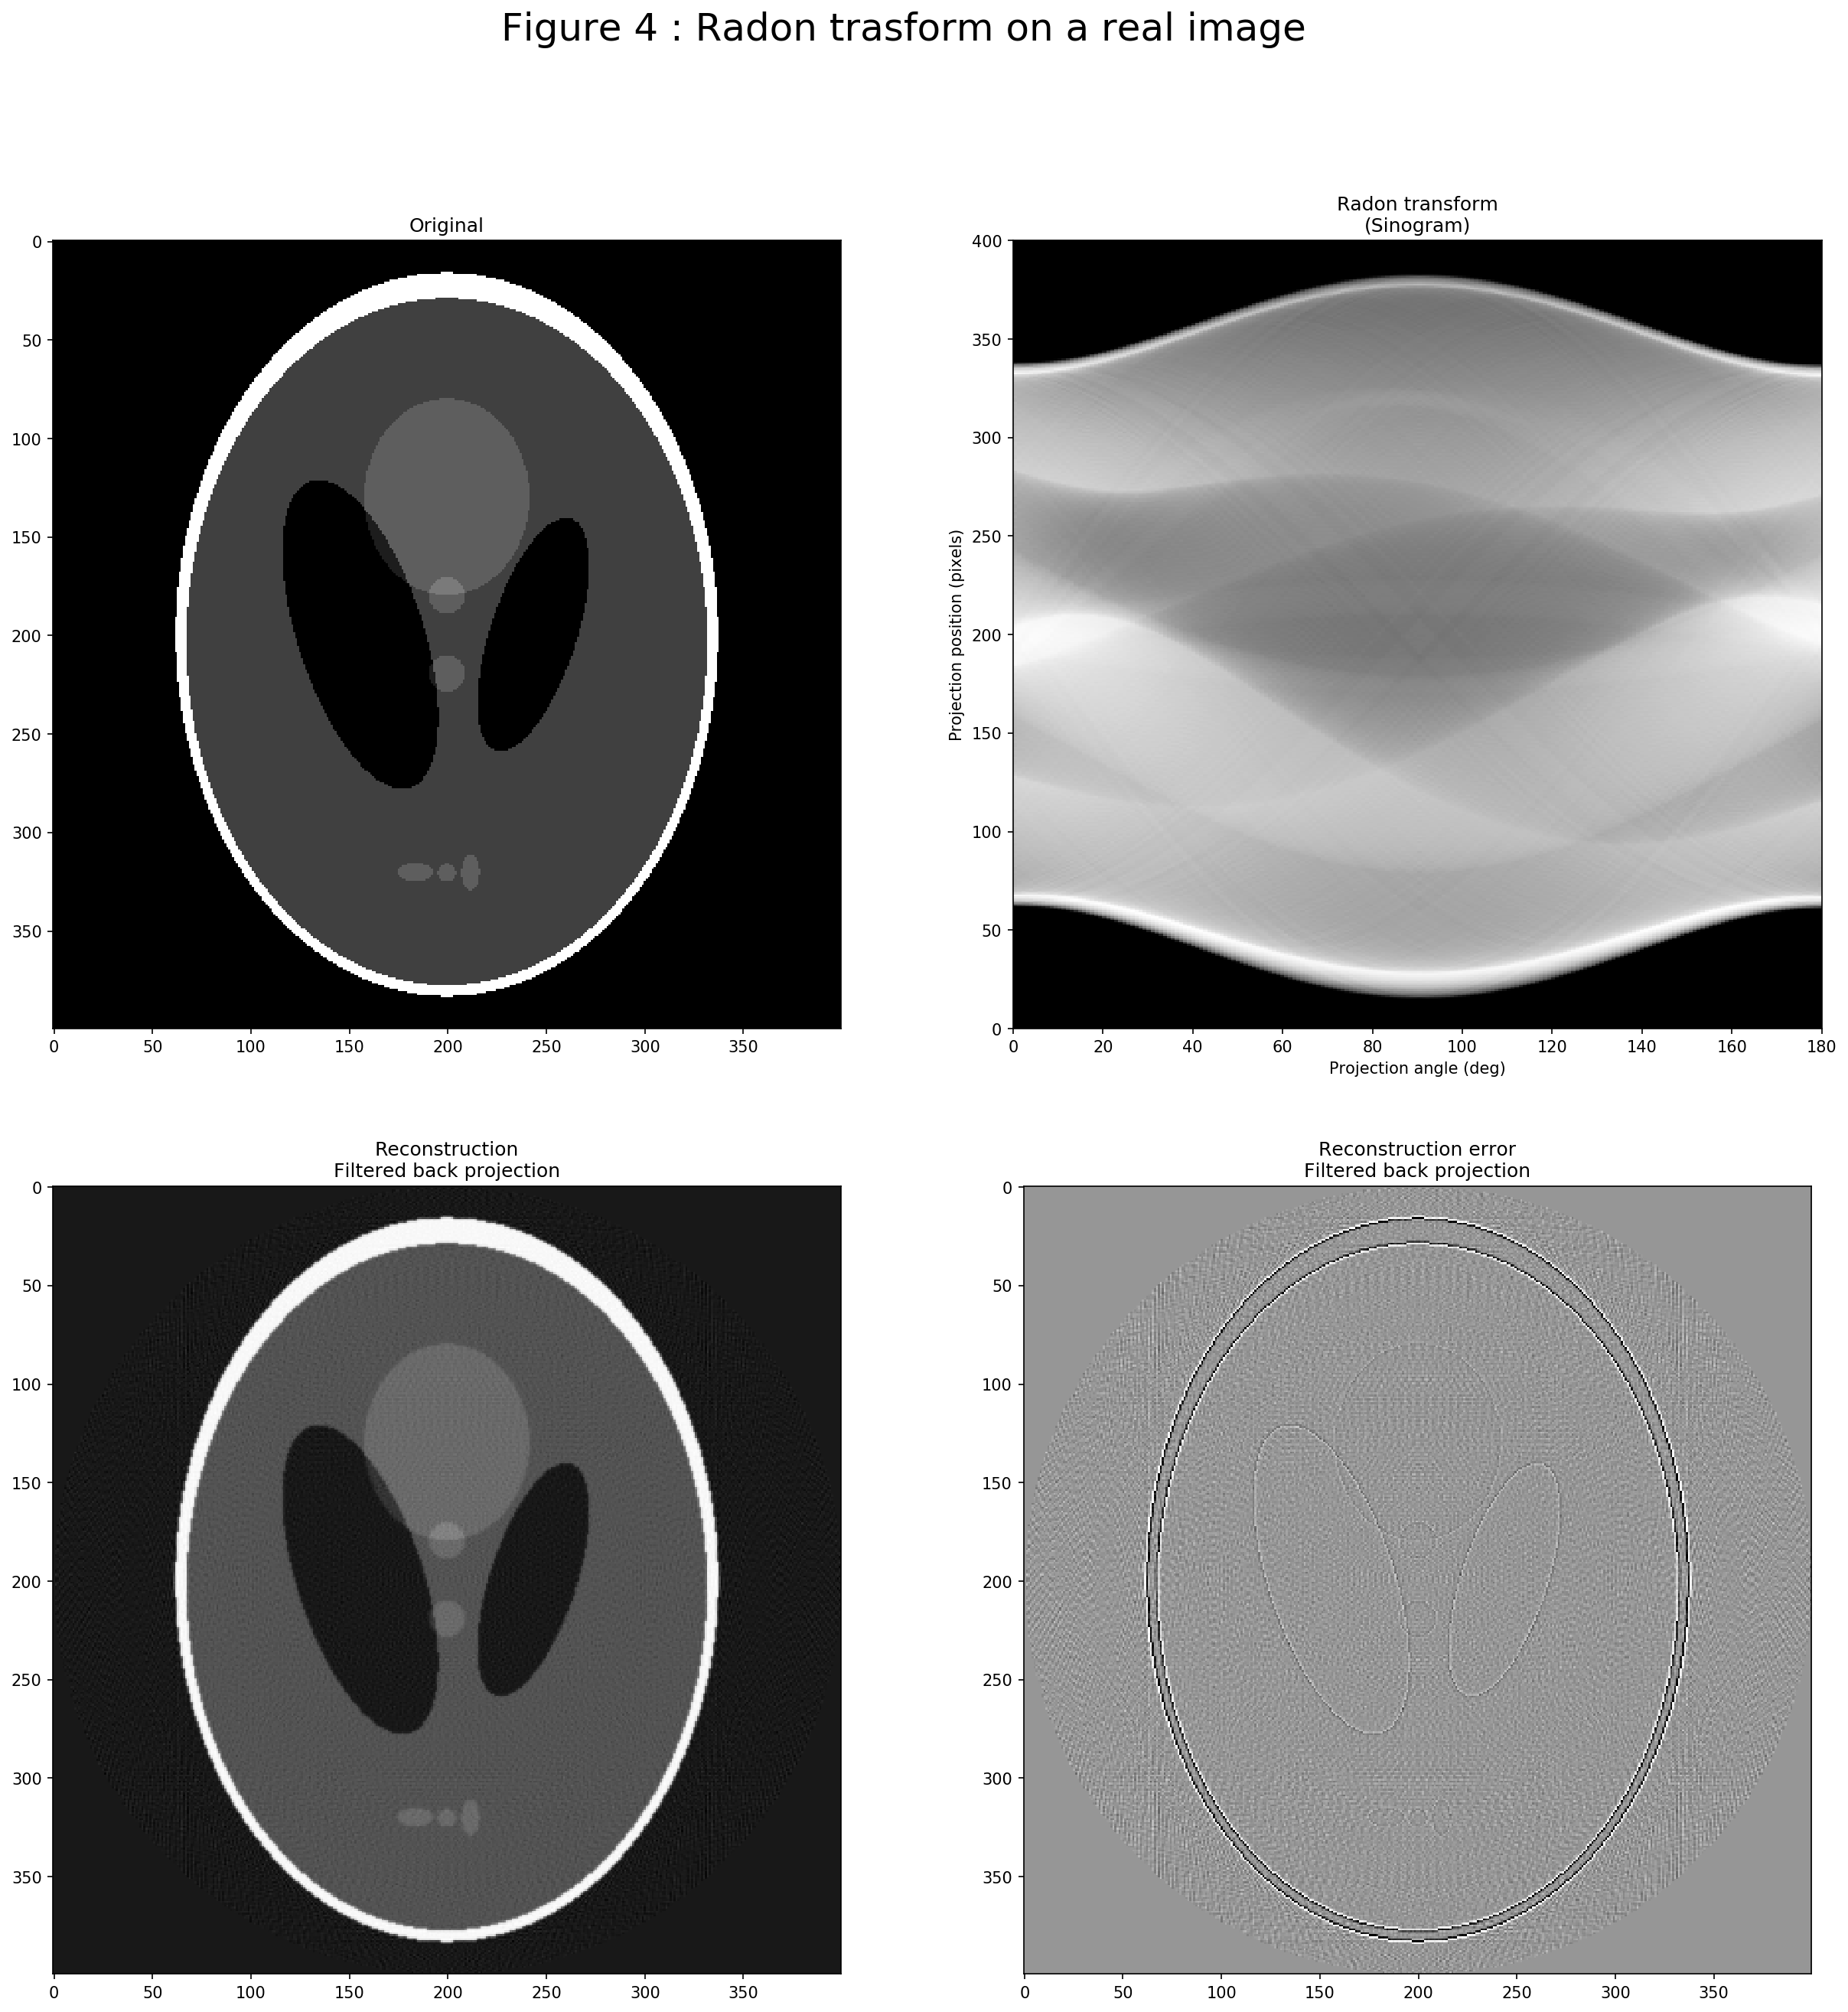

In [5]:
image = shepp_logan_phantom()

theta = np.linspace(0., 180., max(image.shape)/2, endpoint=False)
fig, axs = plt.subplots(2,2, figsize=(20,20), dpi=150)
fig.suptitle('Figure 4 : Radon trasform on a real image', fontsize=24)

axs[0, 0].set_title("Original")
axs[0, 0].imshow(image, cmap=plt.cm.Greys_r)

sinogram = radon(image, theta=theta, circle=True)
axs[0, 1].set_title("Radon transform\n(Sinogram)")
axs[0, 1].set_xlabel("Projection angle (deg)")
axs[0, 1].set_ylabel("Projection position (pixels)")
axs[0, 1].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image 

imkwargs = dict(vmin=-0.2, vmax=0.2)

axs[1, 0].set_title("Reconstruction\nFiltered back projection")
axs[1, 0].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
axs[1, 1].set_title("Reconstruction error\nFiltered back projection")
axs[1, 1].imshow(error, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

Here we can see the implementation of the Radon transform on a real image "shepp_logan_phantom". If we only use the Radon and directly the inverse Radon we observe that the reconstruction isn't the same (4th image on Figure 4 being the absolute difference). To be perfect, the Radon transform should have continuous theta input (which is not the case here). We can observe the presence of a circle around the reconstructed image corresponding to the several angle took for the transform (theta). Sampling more the angle theta has an influence on the resolution of the image, but mostly on the high frequencies. We can notice that dividers of 180 (or 360) leads to a peak of absolute error.

### III-2 Sampling influence

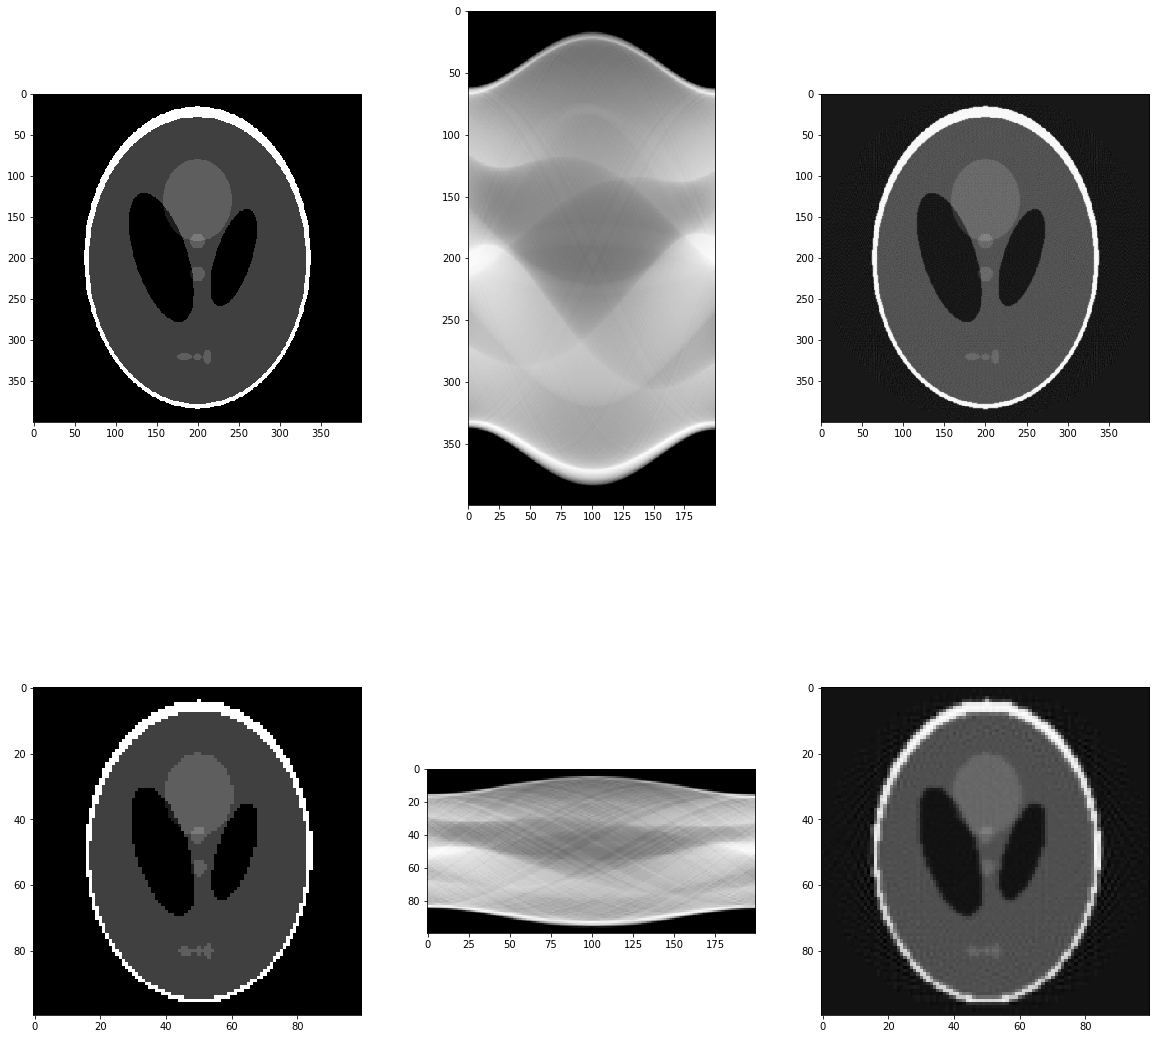

In [6]:
theta = np.linspace(0., 180., max(image.shape)/2, endpoint=False)

step = 4;
image = shepp_logan_phantom()
shape_image = np.shape(image)
shape_sub_sampled = (shape_image[0]//step, shape_image[1]//step)
sub_sampled = np.zeros(shape_sub_sampled)
for i in range(shape_sub_sampled[0]):
    for j in range(shape_sub_sampled[1]):
        sub_sampled[i][j] = image[step * i][step * j]

sinogram = radon(image, theta=theta, circle=True)
sinogram_sub = radon(sub_sampled, theta=theta, circle=True)

reconstruction = iradon(sinogram, theta=theta, circle=True)
reconstruction_sub = iradon(sinogram_sub, theta=theta, circle=True)

plt.figure(figsize = (20,20))
plt.subplot(231)
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.subplot(232)
plt.imshow(sinogram, cmap=plt.cm.Greys_r)
plt.subplot(233)
plt.imshow(reconstruction, cmap=plt.cm.Greys_r)

plt.subplot(234)
plt.imshow(sub_sampled, cmap=plt.cm.Greys_r)
plt.subplot(235)
plt.imshow(sinogram_sub, cmap=plt.cm.Greys_r)
plt.subplot(236)
plt.imshow(reconstruction_sub, cmap=plt.cm.Greys_r)

plt.show()

Here we decided to sample the image and to see the impact on the recontrcuted image. If we first look at the radon transform, each component seems clearer and less smooth as for the original image. When we recontrsuct the image, a blurry effect appears. Sampling still appears and the reconstruction suffers from a lower quality. If we sample the Radon transform instead of the image itself, we then observe that the reconstruction suffers from a huge lack of resolution (and appears smaller after recontruction). These sampling effects are comparable to those of the Fourier transform (even if we have some difficulties to draw a parallel between Shannon Nyquist frequencies).

### III-3 Noise and filtering

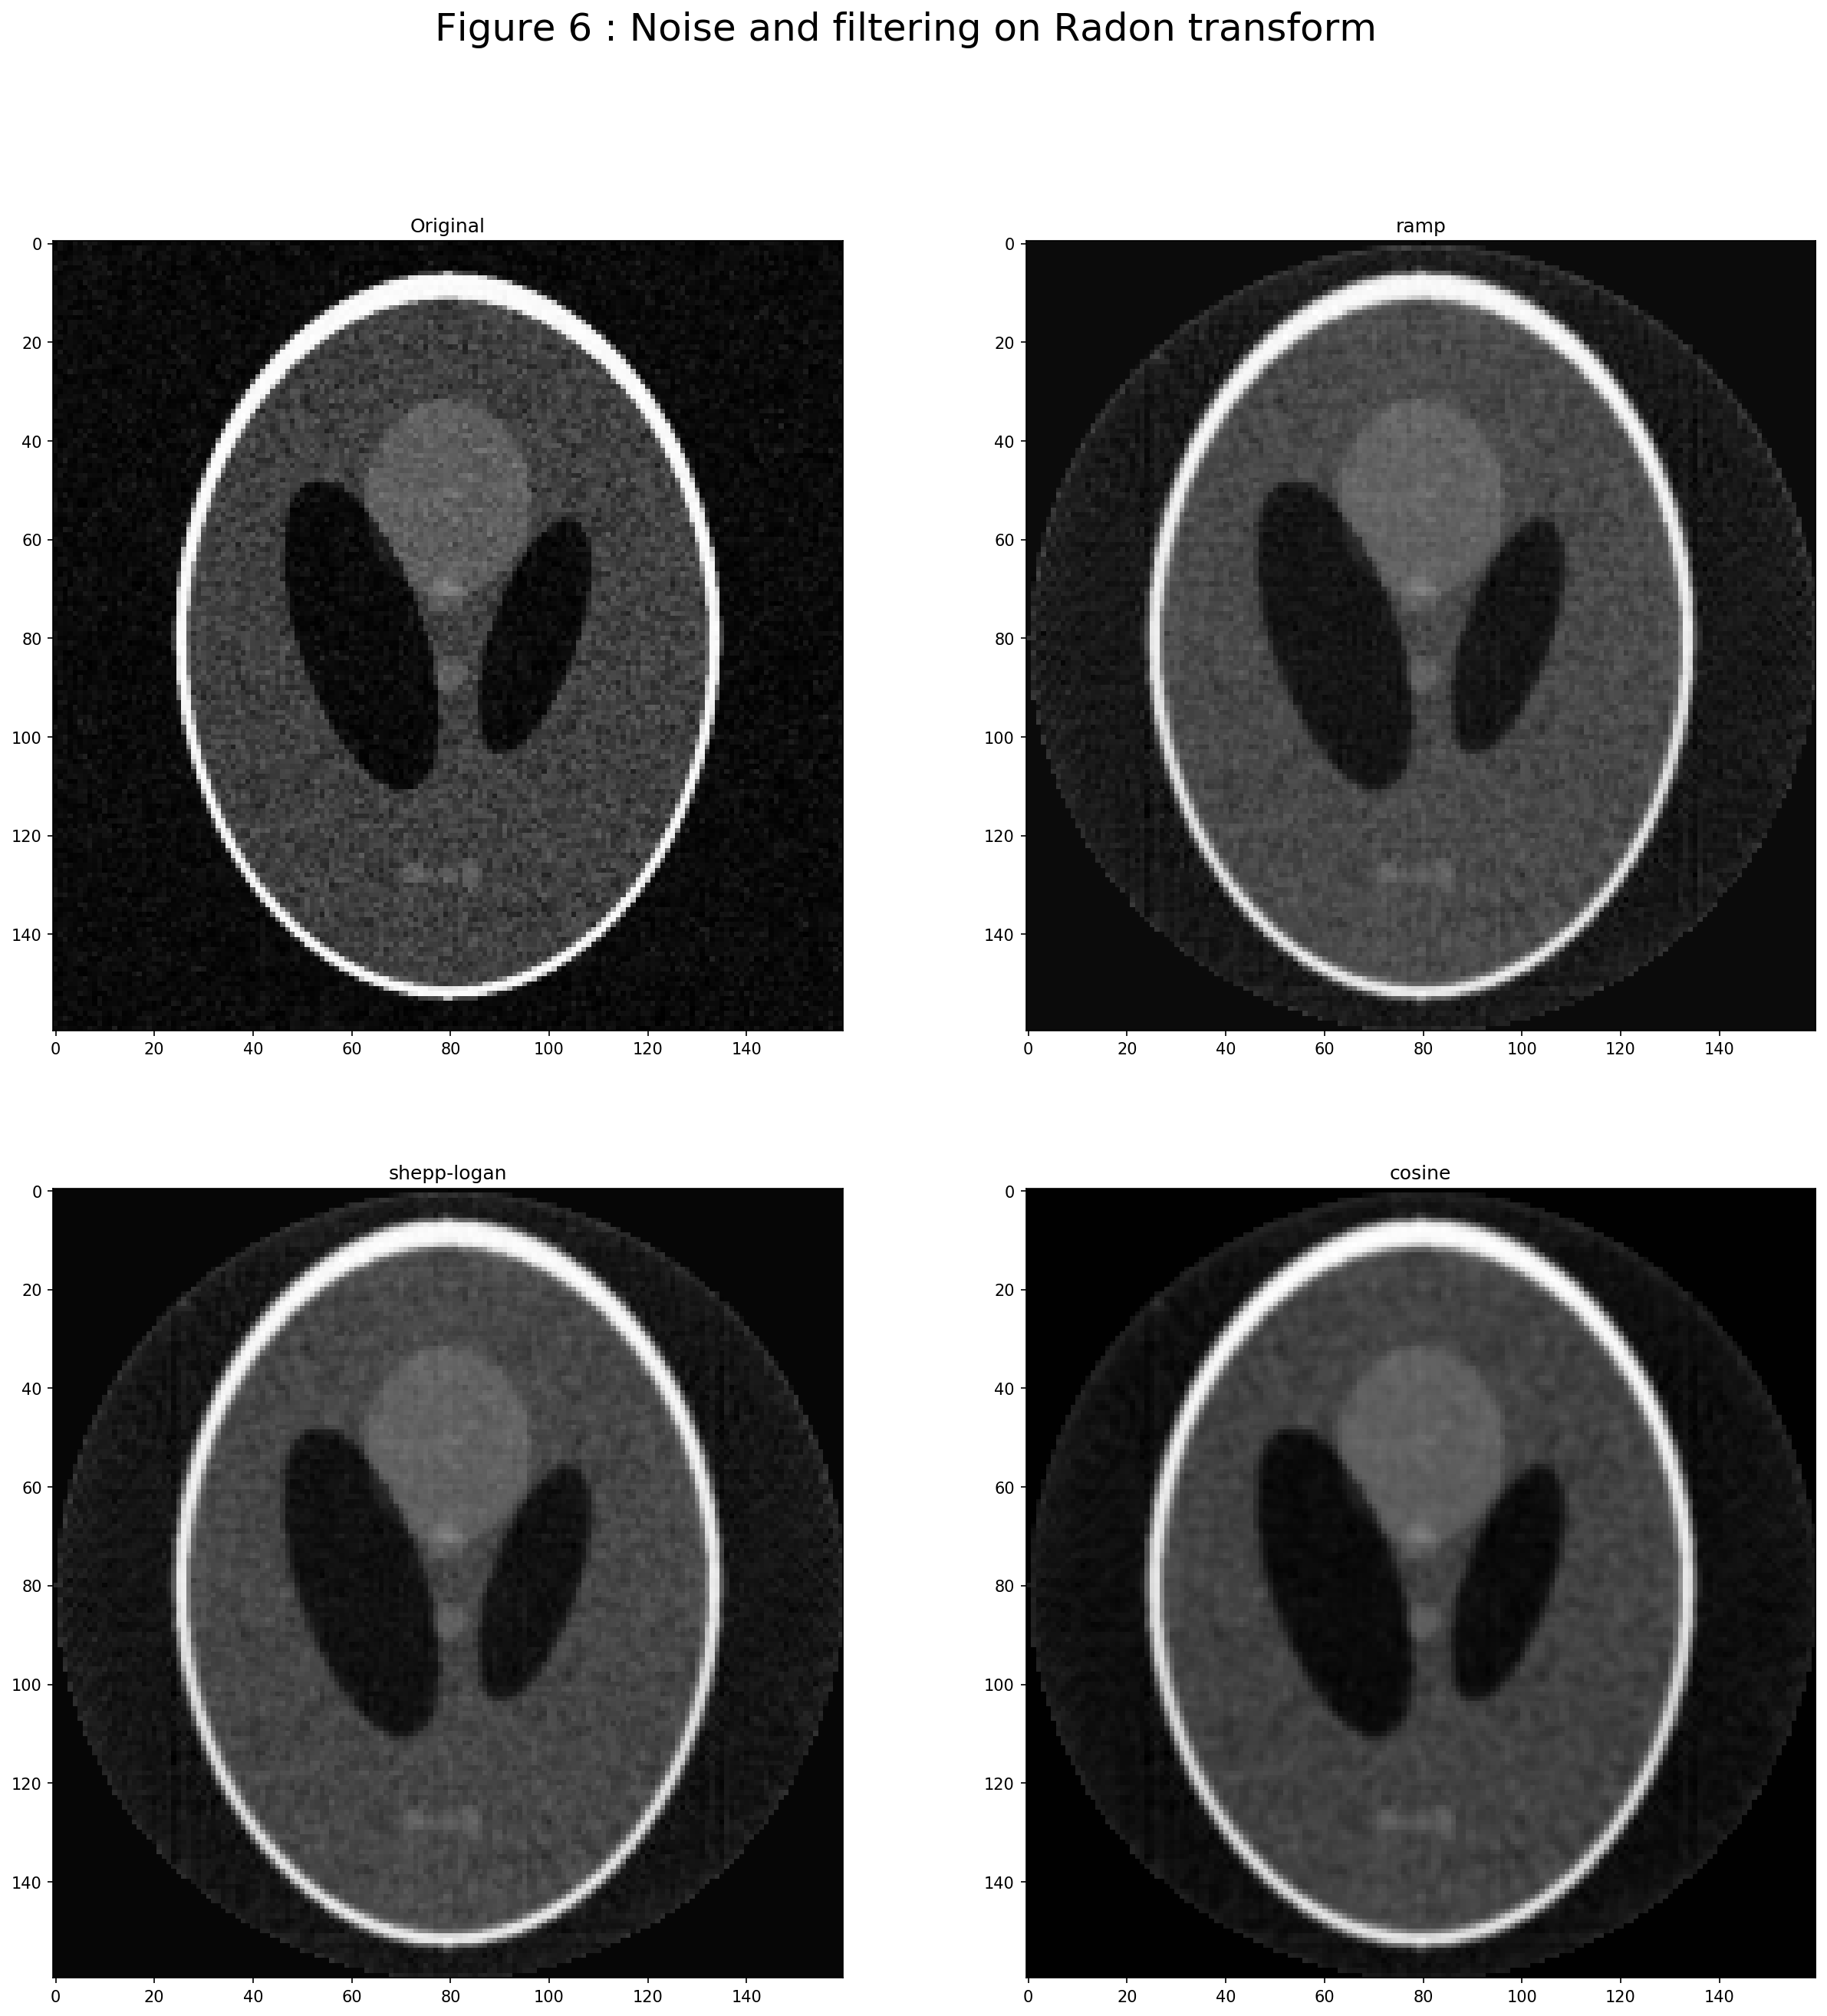

In [7]:
image = random_noise(shepp_logan_phantom())
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)

theta = np.linspace(0.,180., max(image.shape)/2, endpoint=False)
fig, axs = plt.subplots(2,2, figsize=(20,20), dpi=150)
fig.suptitle('Figure 6 : Noise and filtering on Radon transform', fontsize=24)

axs[0, 0].set_title("Original")
axs[0, 0].imshow(image, cmap=plt.cm.Greys_r)
sinogram = radon(image, theta=theta, circle=True)


axs[0, 1].imshow(iradon(sinogram, theta=theta, circle=True, filter = 'ramp'), cmap=plt.cm.Greys_r)
axs[0, 1].set_title('ramp')
axs[1, 0].imshow(iradon(sinogram, theta=theta, circle=True, filter = 'shepp-logan'), cmap=plt.cm.Greys_r)
axs[1, 0].set_title('shepp-logan')
axs[1, 1].imshow(iradon(sinogram, theta=theta, circle=True, filter = 'cosine'), cmap=plt.cm.Greys_r)
axs[1, 1].set_title('cosine')
plt.show()

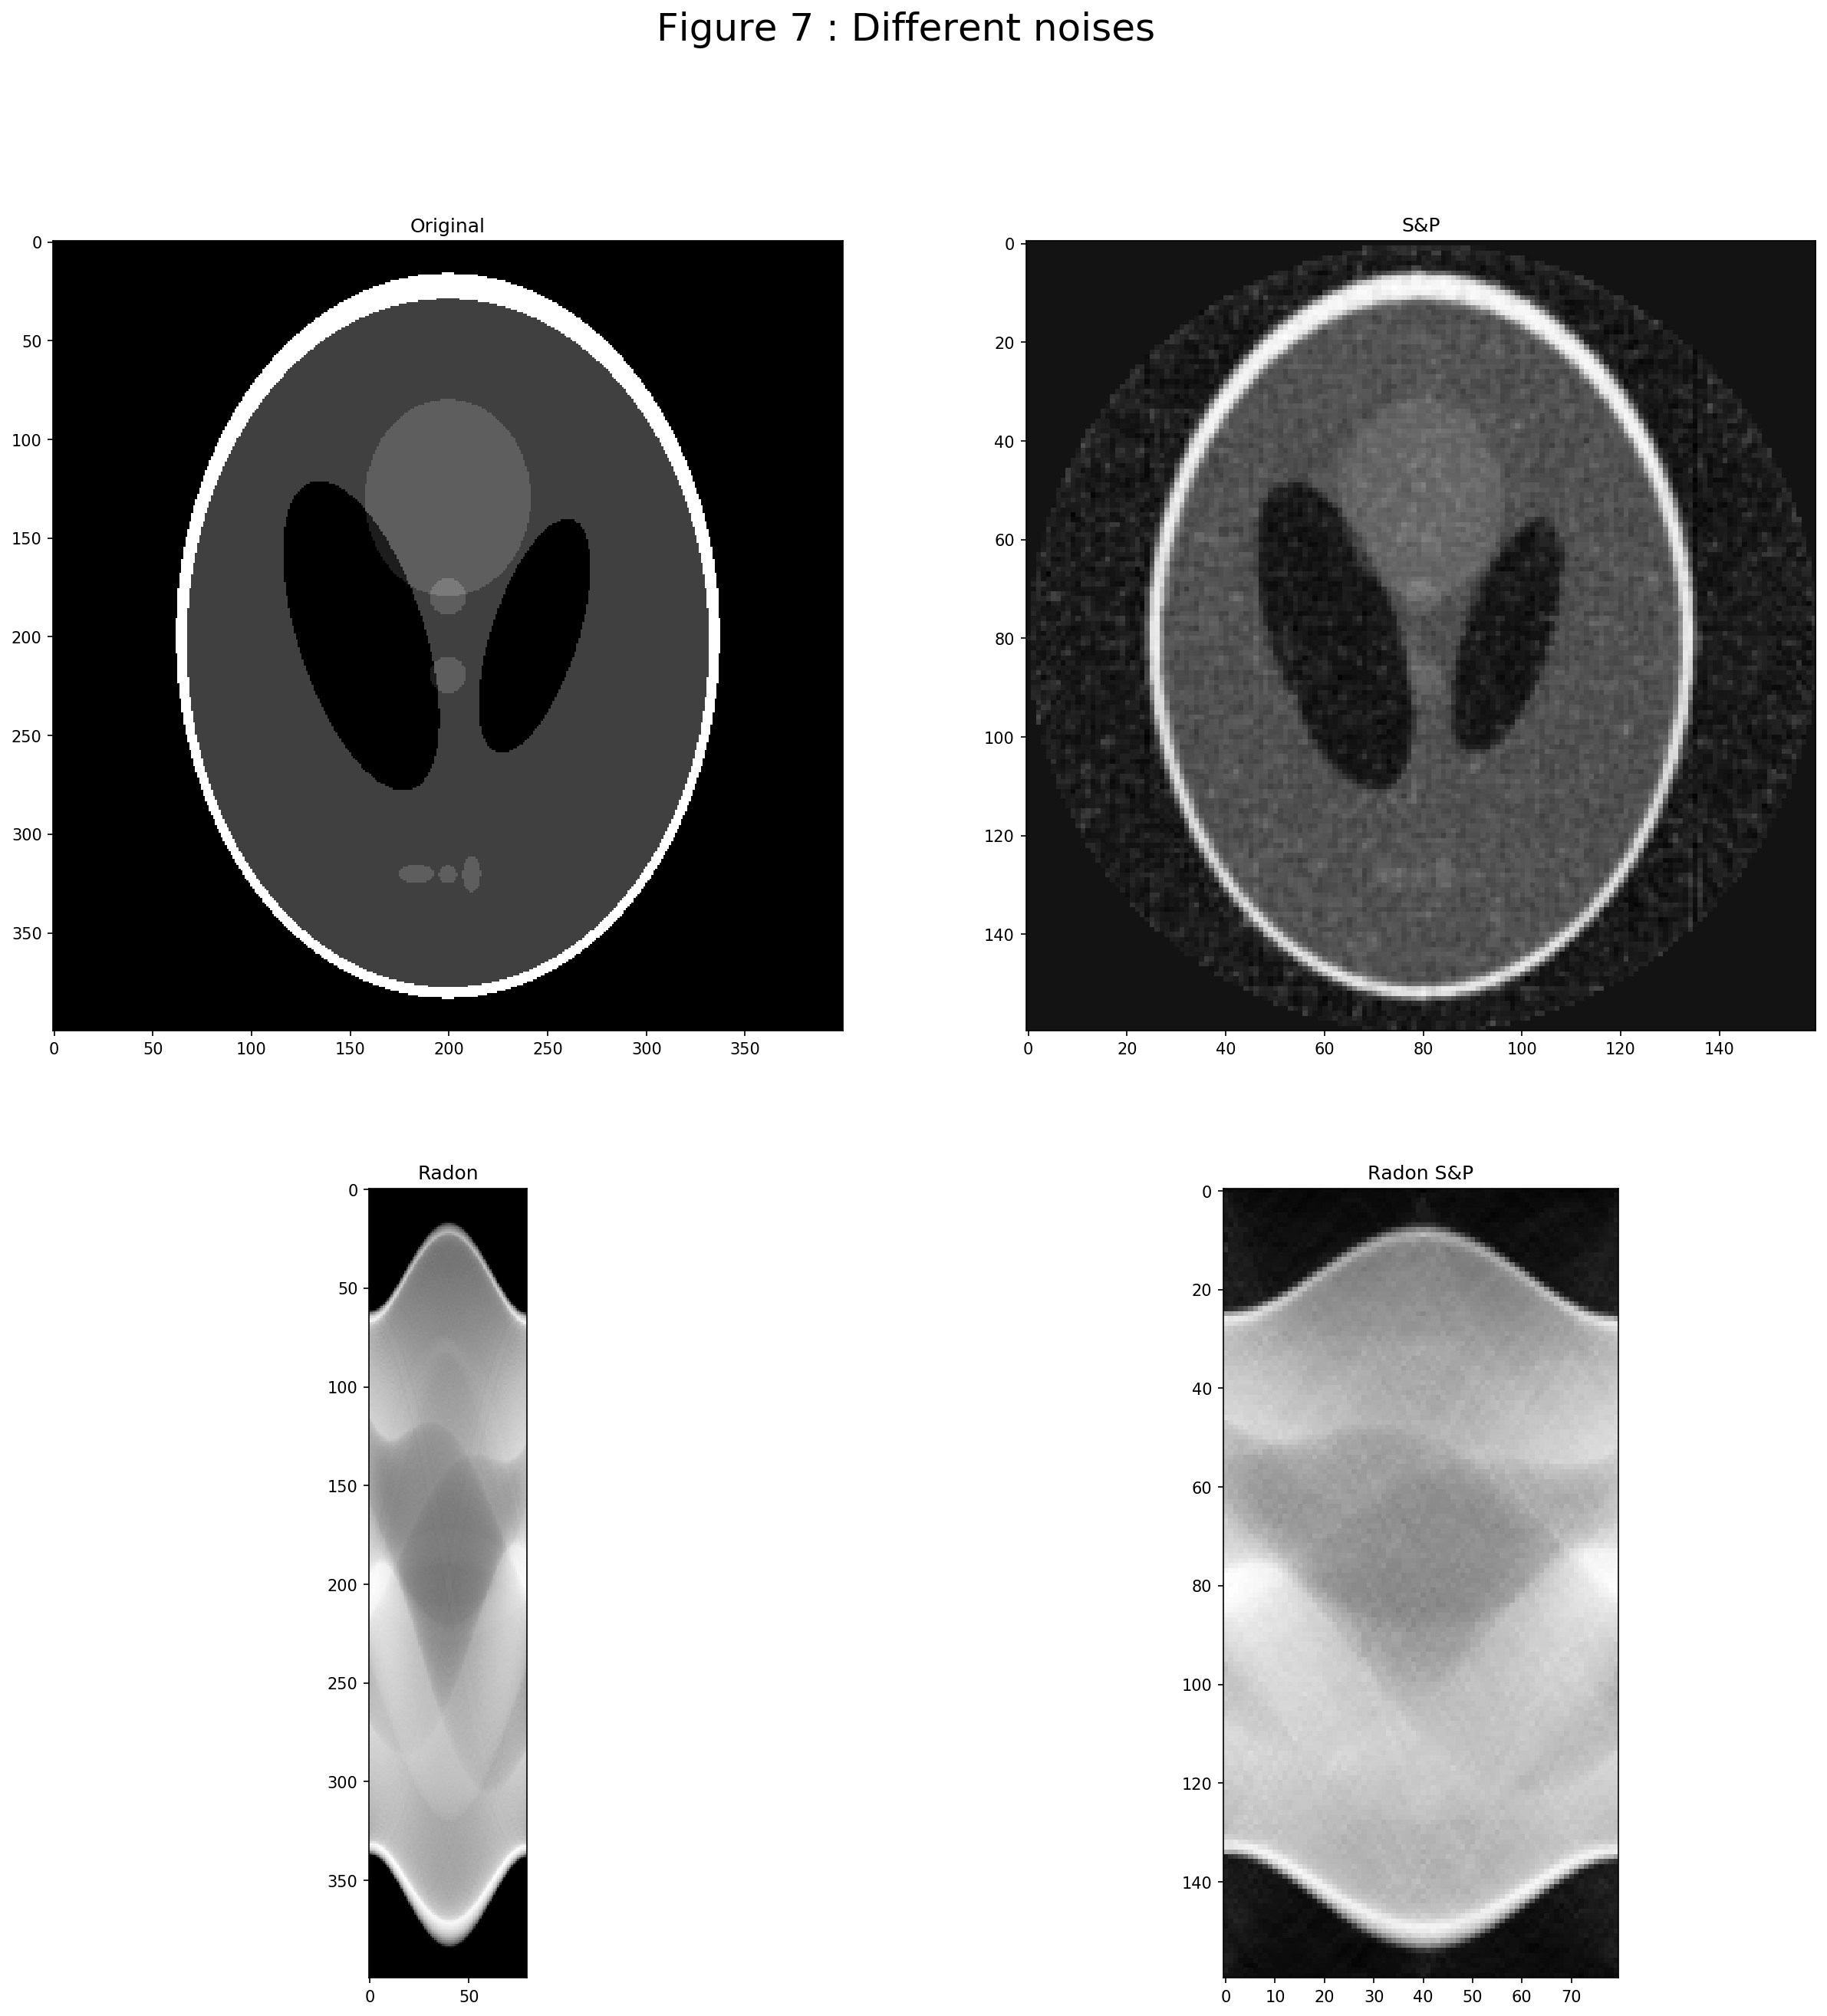

In [8]:
image = random_noise(shepp_logan_phantom(), mode ='s&p')
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
im = shepp_logan_phantom()

theta = np.linspace(0.,180., max(image.shape)/2, endpoint=False)
fig, axs = plt.subplots(2,2, figsize=(20,20), dpi=150)
fig.suptitle('Figure 7 : Different noises', fontsize=24)

sinogram = radon(image, theta=theta, circle=True)

axs[0, 0].imshow(im, cmap=plt.cm.Greys_r)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(iradon(sinogram, theta=theta, circle=True, filter = 'shepp-logan'), cmap=plt.cm.Greys_r)
axs[0, 1].set_title("S&P")
axs[1, 0].imshow(radon(im, theta=theta, circle=True), cmap=plt.cm.Greys_r)
axs[1, 0].set_title("Radon")
axs[1, 1].imshow(sinogram, cmap=plt.cm.Greys_r)
axs[1, 1].set_title("Radon S&P")
plt.show()

Finally we can observe the influence of noise and filtering on the Radon transform. Radon transform being often used in biomedical stuff, noise effects seems relevant. Here we added a gaussian noise to the original image and then filtered its Radon transform. As supposed, filters tend to absorb local resolution in order to increase global quality. We can get rid off some noise particles but we also lose local informations. With a salt and pepper noise (Figure 7), we notice that filtering is worse. In fact, salt and pepper noise "targets" a particular pixel and disrupts local resolution. These corrupted pixels have then a huge influence on the transform. We can notice on the Radon transform that it isn't smooth and that the corrupted pixels appear (irregularities in the transform).

## Conclusion

This lab made us manipulate the Radon transform and see its limits, in particular with sampling and filtering. Seeing interpolation influence or having curve showing the evolution of the MSE depending on the different values would have been a good understanding tools.